In [40]:
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt

#Preprocessing

In [41]:
IMAGE_SIZE=256
Batch_Size=32

In [42]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "F:\AI_Edu\skin_cancer\Train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=Batch_Size
)

Found 2239 files belonging to 9 classes.


In [43]:
class_names=dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [44]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)          # (32, 256, 256, 3)
    print(label_batch.numpy())        # array of class indices


(32, 256, 256, 3)
[3 5 4 5 4 4 3 6 1 3 1 5 1 7 6 4 1 3 3 5 0 3 3 8 7 4 5 4 7 3 5 1]


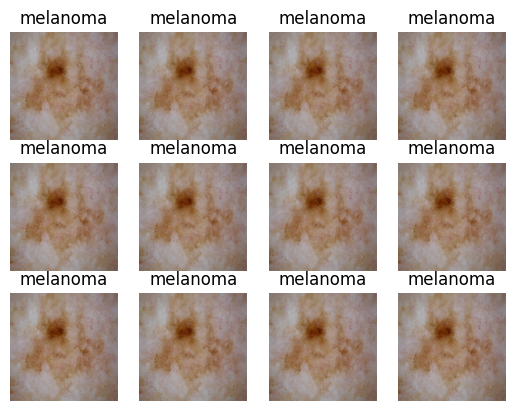

In [45]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [46]:
train_size=0.80
len(dataset)*train_size

56.0

In [47]:
train_ds=dataset.take(56)

In [48]:
len(train_ds)

56

In [49]:
test_ds=dataset.skip(56)

In [50]:
len(test_ds)

14

In [51]:
val_size=0.1
val_ds=test_ds.take(6)
len(val_ds)

6

In [52]:
test_ds=test_ds.skip(6)

In [53]:
def get_dataset_partitions_tf(ds, 
                              train_split=0.8, 
                              val_split=0.1, 
                              test_split=0.1, 
                              shuffle=True, 
                              shuffle_size=10000):

    assert (train_split + val_split + test_split) == 1, "Splits must add up to 1."

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [54]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [55]:
len(train_ds)


56

In [56]:
len(val_ds)


7

In [57]:
len(test_ds)

7

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [59]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [60]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


#Neural Network Building

In [61]:
input_shape = (Batch_Size, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy (from_logits=False),
    metrics=['accuracy']

)

In [64]:
EPOCHS=10
history=model.fit (
    train_ds,
    epochs=EPOCHS,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
56/56 [==============================] - 53s 848ms/step - loss: 2.0694 - accuracy: 0.1836 - val_loss: 2.0392 - val_accuracy: 0.1473
Epoch 2/10
56/56 [==============================] - 44s 788ms/step - loss: 2.0210 - accuracy: 0.2154 - val_loss: 1.9060 - val_accuracy: 0.2768
Epoch 3/10
56/56 [==============================] - 44s 782ms/step - loss: 1.9256 - accuracy: 0.2779 - val_loss: 1.7165 - val_accuracy: 0.2946
Epoch 4/10
56/56 [==============================] - 44s 781ms/step - loss: 1.8702 - accuracy: 0.2913 - val_loss: 1.6624 - val_accuracy: 0.3527
Epoch 5/10
56/56 [==============================] - 44s 785ms/step - loss: 1.7675 - accuracy: 0.3426 - val_loss: 1.8068 - val_accuracy: 0.2500
Epoch 6/10
56/56 [==============================] - 45s 800ms/step - loss: 1.7249 - accuracy: 0.3672 - val_loss: 1.6830 - val_accuracy: 0.3259
Epoch 7/10
56/56 [==============================] - 43s 764ms/step - loss: 1.6530 - accuracy: 0.4023 - val_loss: 1.5602 - val_accuracy: 0.4777

In [65]:
scores=model.evaluate(test_ds)

7/7 [==============================] - 4s 159ms/step - loss: 1.3114 - accuracy: 0.5291


In [66]:
scores

[1.3113746643066406, 0.5291479825973511]

In [67]:
history

In [68]:
history.history['loss'][:5]

[2.0694377422332764,
 2.0209782123565674,
 1.9255669116973877,
 1.8702392578125,
 1.7675093412399292]

first image to predict
actual label: nevus
1/1 [==============================] - 0s 229ms/step
predicted label: pigmented benign keratosis


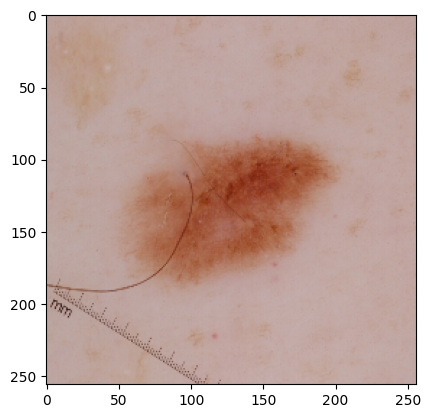

In [69]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
def predict (model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence


1/1 [==============================] - 0s 22ms/step


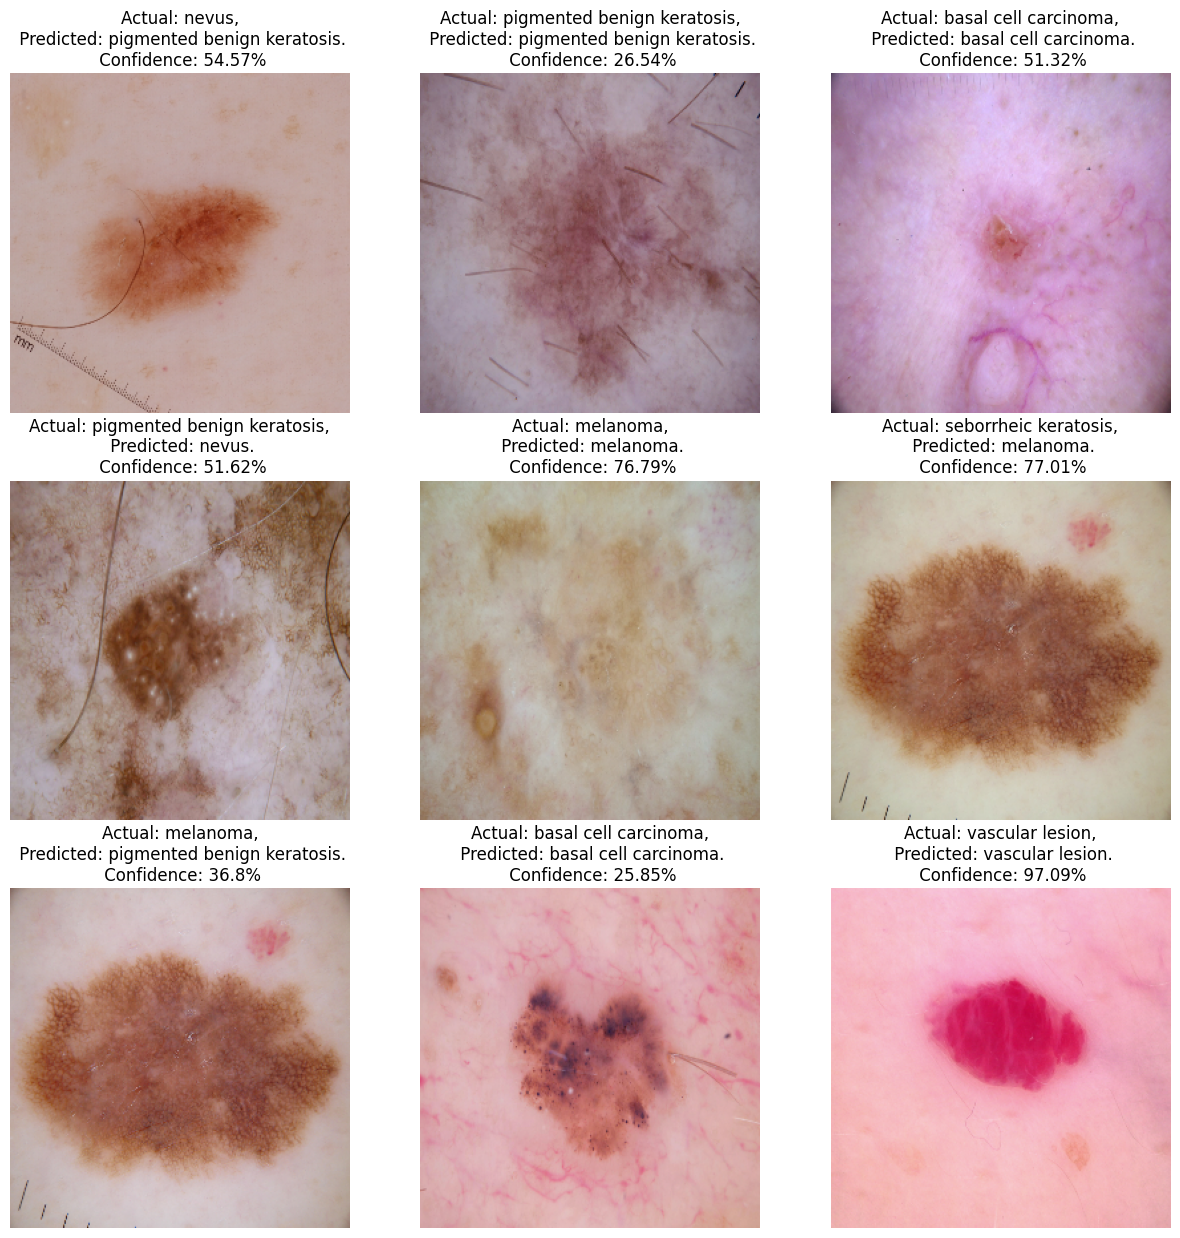

In [71]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 22ms/step


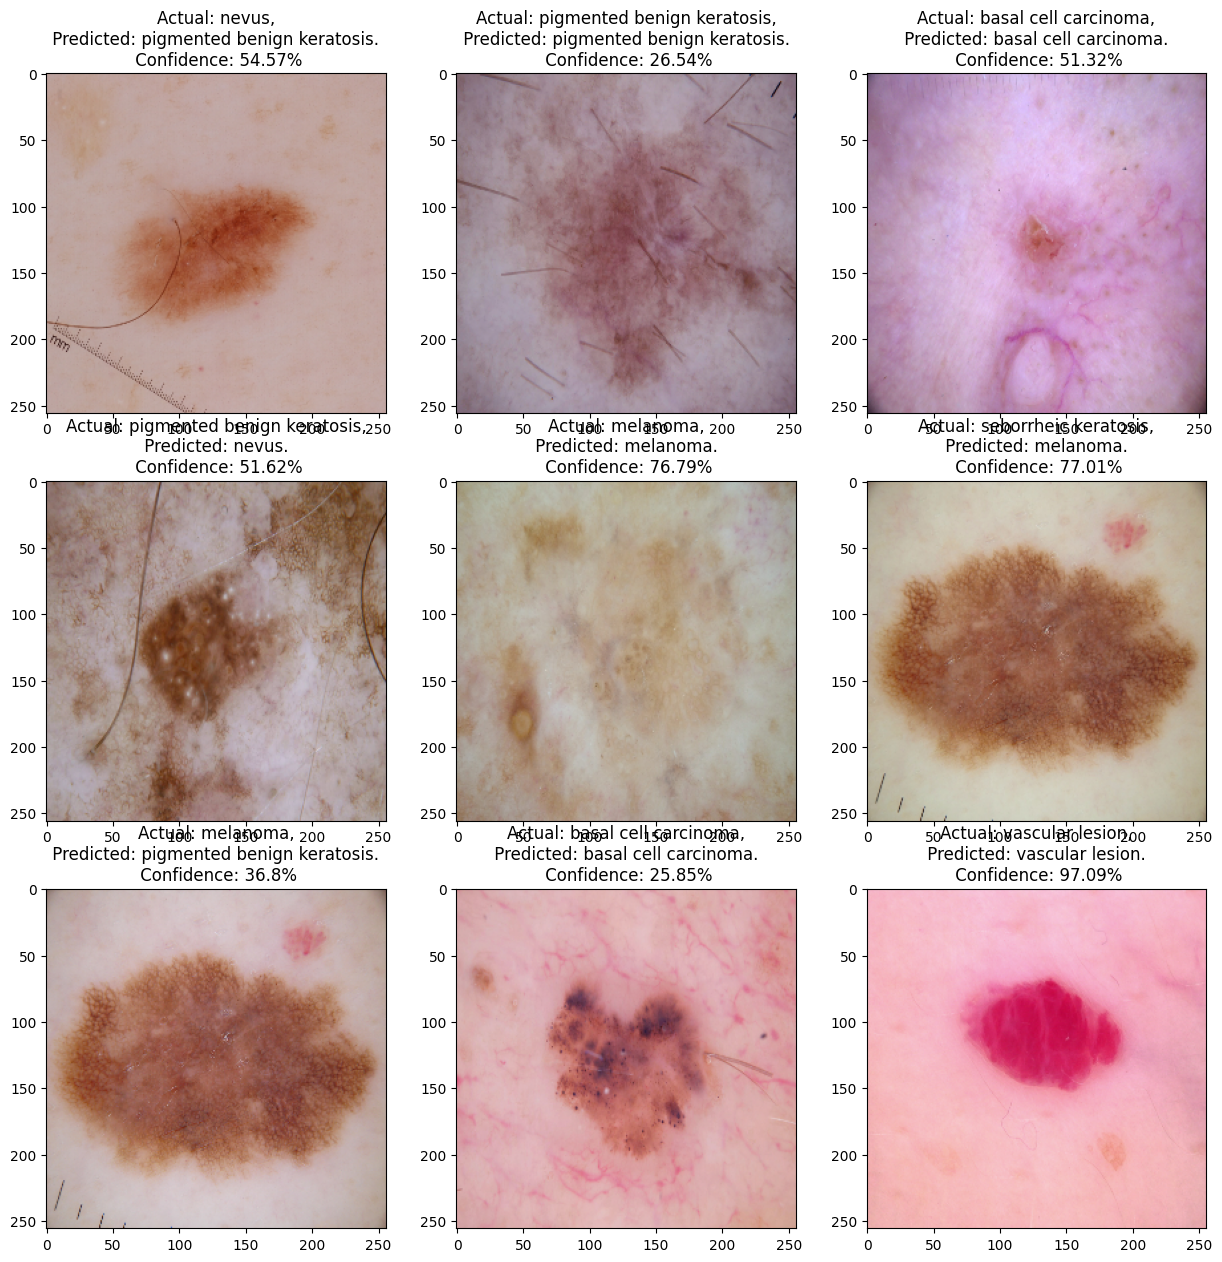

In [72]:
plt.figure (figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range (9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")

In [73]:
import os

model_version = 1
save_path = os.path.join(r"F:\AI_Edu\skin_cancer\models", f"model_v{model_version}.keras")

model.save(save_path)   # saves in .keras format (recommended)



In [74]:
import tensorflow as tf
from tensorflow import keras
print("TF:", tf.__version__)
print("Keras:", keras.__version__)
print("TF path:", tf.__path__)
print("Keras path:", keras.__path__)


TF: 2.12.0
Keras: 2.12.0
TF path: ['f:\\AI_Edu\\ml\\Lib\\site-packages\\keras\\api\\_v2', 'f:\\AI_Edu\\ml\\Lib\\site-packages\\tensorflow_estimator\\python\\estimator\\api\\_v2', 'f:\\AI_Edu\\ml\\Lib\\site-packages\\tensorboard\\summary\\_tf', 'f:\\AI_Edu\\ml\\Lib\\site-packages\\tensorflow', 'f:\\AI_Edu\\ml\\Lib\\site-packages\\tensorflow\\_api\\v2']
Keras path: ['f:\\AI_Edu\\ml\\Lib\\site-packages\\keras\\api\\_v2\\keras']
